[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers

## Review

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.

## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## Default overwriting state

Let's use a `TypedDict` as our state schema.

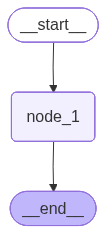

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

Let's look at the state update, `return {"foo": state['foo'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.

So, it will just overwrite the value of `foo` in `node_1`:

```
return {"foo": state['foo'] + 1}
```

If we pass `{'foo': 1}` as input, the state returned from the graph is `{'foo': 2}`.

## Branching

Let's look at a case where our nodes branch.

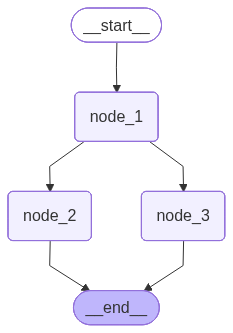

In [4]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 3---
---Node 2---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We see a problem!

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*.

This is ambiguous for the graph! Which state should it keep?

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function.

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

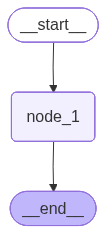

In [6]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list.

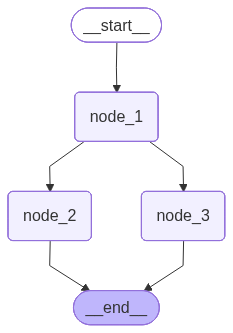

In [8]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [9]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`.

In [10]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state).

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [11]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

In `node_1`, we append the value 2.

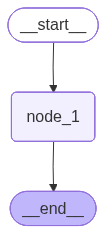

TypeError occurred: can only concatenate list (not "NoneType") to list


In [12]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer. We can see that no error is thrown.

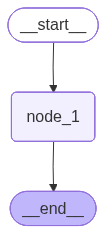

---Node 1---
{'foo': [2]}


In [13]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate).

* `MessagesState` has a built-in `messages` key
* It also has a built-in `add_messages` reducer for this key

These two are equivalent.

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [14]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    added_key_1: str
    added_key_2: str
    # etc

Let's talk a bit more about usage of the `add_messages` reducer.

In [15]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='c255cdc9-aa53-4641-907b-f062919f6320'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='bf65b85c-74be-4b1f-b6ab-0bc0364a17ba'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='91a4b3a2-1a74-4ed6-b399-1d5fcc09fd77')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [16]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/).

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [17]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [18]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

We'll see this put into practice a bit later.

# MY EXAMPLES:

## Default overwriting state

Demonstrate the default state overwriting behavior when no reducer is specified.


In [31]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    value: int

# Define a simple Python function, increment_node
def increment_node(state):
    print("---Increment Node---")
    return {"value": state['value'] + 1}

In [33]:
builder = StateGraph(State)

builder.add_node("increment", increment_node)

# Add an edge from START to increment_node and from increment_node to END
builder.add_edge(START, "increment")
builder.add_edge("increment", END)

graph = builder.compile()

# Invoke the compiled graph with an initial state
initial_state = {"value": 5}
result = graph.invoke(initial_state)

print(result)

---Increment Node---
{'value': 6}


## Branching and invalid update error

Demonstrate how branching without a reducer can lead to an `InvalidUpdateError`.


In [34]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.errors import InvalidUpdateError

class State(TypedDict):
    value: int

# Define three simple Python functions (nodes)
def node_a(state):
    print("---Node A---")
    return {"value": state['value'] + 1}

def node_b(state):
    print("---Node B---")
    return {"value": state['value'] + 1}

def node_c(state):
    print("---Node C---")
    return {"value": state['value'] + 1}

In [35]:
builder = StateGraph(State)

# Add the three nodes to the graph
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

builder.add_edge(START, "node_a")
builder.add_edge("node_a", "node_b")
builder.add_edge("node_a", "node_c")

builder.add_edge("node_b", END)
builder.add_edge("node_c", END)

graph = builder.compile()

# Invoke the compiled graph with an initial state and wrap in try-except
try:
    graph.invoke({"value": 1})
except InvalidUpdateError as e:
    # Catch and print the expected error
    print(f"Caught expected error: {e}")

---Node A---
---Node B---
---Node C---
Caught expected error: At key 'value': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


## Using `operator.add` as a reducer

Implement an example using `operator.add` with an Annotated list to handle concurrent updates.


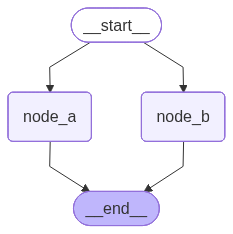

---Node A---
---Node B---
{'foo': [1, 2, 3]}


In [36]:
from typing import Annotated
from operator import add
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_a(state):
    print("---Node A---")
    # Return a single-element list derived from the input state's foo list
    # Using state['foo'][0] assumes the initial input is a list with at least one element
    return {"foo": [state['foo'][0] + 1]}

def node_b(state):
    print("---Node B---")
    # Return a single-element list derived from the input state's foo list
    return {"foo": [state['foo'][0] + 2]}

builder = StateGraph(State)

builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_edge(START, "node_a")
builder.add_edge(START, "node_b")
builder.add_edge("node_a", END)
builder.add_edge("node_b", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

initial_state = {"foo": [1]}
result = graph.invoke(initial_state)

print(result)

## Handling `none` with `operator.add`

Demonstrate the error that occurs when `operator.add` is used with `None` values.


In [37]:
from typing import Annotated
import operator
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: Annotated[list[int], operator.add]

# Define a Python function increment_node that attempts to increment the last element of the foo list.
def increment_node(state):
    print("---Increment Node---")
    # This will raise a TypeError if state['foo'] is None
    return {"foo": [state['foo'][-1] + 1]}

builder = StateGraph(State)
builder.add_node("increment", increment_node)
builder.add_edge(START, "increment")
builder.add_edge("increment", END)

graph = builder.compile()

# Invoke the compiled graph with an initial state where the value for the foo key is None.
# Wrap the invocation in a try...except TypeError block to catch and print the expected error.
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom reducer for handling `none`

Create a custom reducer to handle `None` values gracefully and show its implementation in an example.


In [38]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Define a custom reducer function named reduce_list_safe
def reduce_list_safe(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None."""
    left = left if left is not None else []
    right = right if right is not None else []
    return left + right

class SafeState(TypedDict):
    foo: Annotated[list[int], reduce_list_safe]

# Define a Python function named append_value_node
def append_value_node(state):
    print("---Append Value Node---")
    # The custom reducer handles the None case for us, so we can just return the list to append
    return {"foo": [10]}

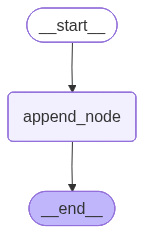

---Append Value Node---
{'foo': [10]}


In [39]:
builder = StateGraph(SafeState)

builder.add_node("append_node", append_value_node)

builder.add_edge(START, "append_node")
builder.add_edge("append_node", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

initial_state = {"foo": None}
result = graph.invoke(initial_state)

print(result)

## Using `add messages` reducer

Demonstrate the use of the built-in `add_messages` reducer for handling messages.


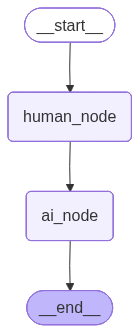

---Adding Human Message---
---Adding AI Message---
{'messages': [HumanMessage(content='Hello AI!', additional_kwargs={}, response_metadata={}, id='c96ab282-b54b-44dd-b102-b8ea347052ea'), AIMessage(content='Hello Human!', additional_kwargs={}, response_metadata={}, id='2a98706f-6cba-44ec-8de7-c40cd725909a')]}


In [40]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class MessagesStateExample(TypedDict):
    messages: Annotated[list, add_messages]

# 3. Define a Python function named add_human_message_node
def add_human_message_node(state):
    print("---Adding Human Message---")
    return {"messages": [HumanMessage(content="Hello AI!")]}

# 4. Define a Python function named add_ai_message_node
def add_ai_message_node(state):
    print("---Adding AI Message---")
    return {"messages": [AIMessage(content="Hello Human!")]}

builder = StateGraph(MessagesStateExample)
builder.add_node("human_node", add_human_message_node)
builder.add_node("ai_node", add_ai_message_node)

builder.add_edge(START, "human_node")
builder.add_edge("human_node", "ai_node")
builder.add_edge("ai_node", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

initial_state = {"messages": []}
result = graph.invoke(initial_state)

print(result)

## Message re-writing with `add messages`

Demonstrate how `add_messages` can re-write messages with the same ID.


In [41]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages

# Initial message list
initial_messages = [
    AIMessage(content="Hello!", name="Bot", id="msg1"),
    HumanMessage(content="Hi there!", name="User", id="msg2"),
    AIMessage(content="How can I help?", name="Bot", id="msg3")
]

new_message_with_duplicate_id = HumanMessage(content="I have a new question.", name="User", id="msg2")

# Use the add_messages function, passing the initial list of messages as the first argument and the list with the duplicate ID message as the second argument.
updated_messages = add_messages(initial_messages, [new_message_with_duplicate_id])

print(updated_messages)

[AIMessage(content='Hello!', additional_kwargs={}, response_metadata={}, name='Bot', id='msg1'), HumanMessage(content='I have a new question.', additional_kwargs={}, response_metadata={}, name='User', id='msg2'), AIMessage(content='How can I help?', additional_kwargs={}, response_metadata={}, name='Bot', id='msg3')]


## Message removal with `add messages`

Demonstrate how to remove messages using `RemoveMessage` with the `add_messages` reducer.


In [42]:
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage
from langgraph.graph.message import add_messages

messages_to_remove_from = [
    AIMessage(content="First message.", name="Bot", id="msg_a"),
    HumanMessage(content="Second message.", name="User", id="msg_b"),
    AIMessage(content="Third message.", name="Bot", id="msg_c"),
    HumanMessage(content="Fourth message.", name="User", id="msg_d"),
]

# 4. Create a list of RemoveMessage objects
ids_to_remove = ["msg_a", "msg_c"]
remove_list = [RemoveMessage(id=msg_id) for msg_id in ids_to_remove]
print(f"Messages to remove: {remove_list}")

# 5. Use the add_messages function, passing the original list of messages as the first argument and the list of RemoveMessage objects as the second argument.
messages_after_removal = add_messages(messages_to_remove_from, remove_list)

print(f"Messages after removal: {messages_after_removal}")

Messages to remove: [RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='msg_a'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='msg_c')]
Messages after removal: [HumanMessage(content='Second message.', additional_kwargs={}, response_metadata={}, name='User', id='msg_b'), HumanMessage(content='Fourth message.', additional_kwargs={}, response_metadata={}, name='User', id='msg_d')]
